In [1]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

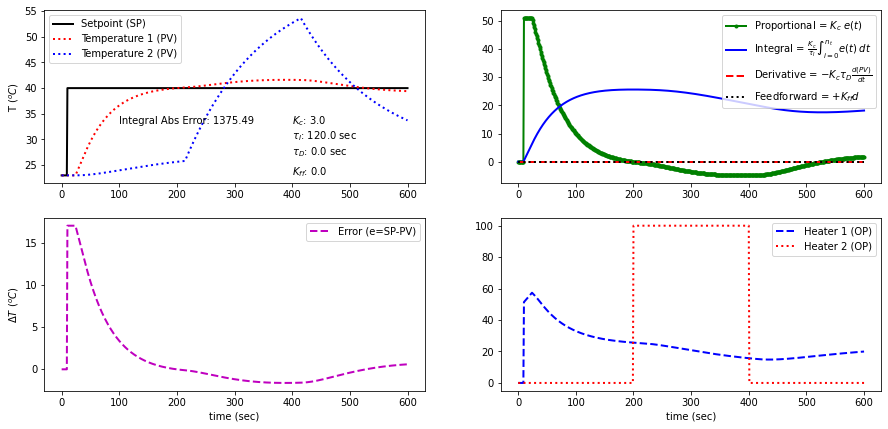

PID with Feedforward Simulator: Adjust Kc, tauI, tauD, and Kff to achieve lowest Integral Abs Error


In [2]:
n = 601 # time points to plot
tf = 600.0 # final time

# TCLab FOPDT
Kp = 0.9
Kd = 0.34
taup = 175.0
thetap = 15.0
y0 = [23.0,23.0]

def process(y,t,u1,u2):
    y1,y2 = y
    dy1dt = (1.0/taup) * (-(y1-y0[0]) + Kp * u1 + Kd * (y2-y1))
    dy2dt = (1.0/taup) * (-(y2-y0[1]) + (Kp/2.0) * u2 + Kd * (y1-y2))
    return [dy1dt,dy2dt]

def pidPlot(Kc,tauI,tauD,Kff):
    y0 = [23.0,23.0]
    t = np.linspace(0,tf,n) # create time vector
    P = np.zeros(n)         # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    FF = np.zeros(n)        # initialize feedforward term
    e = np.zeros(n)         # initialize error
    OP1 = np.zeros(n)       # initialize controller output
    OP2 = np.zeros(n)       # initialize disturbance
    OP2[200:401] = 100      # step up in heater 2
    PV1 = np.ones(n)*y0[0]  # initialize process variable
    PV2 = np.ones(n)*y0[1]  # initialize process variable
    SP = np.ones(n)*y0[0]   # initialize setpoint
    SP[10:] = 40.0          # step up
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        heaters = (OP1[max(0,i-int(thetap))],OP2[max(0,i-int(thetap))])
        y = odeint(process,y0,ts,args=heaters)
        y0 = y[1]                  # record new initial condition
        # calculate new OP with PID
        PV1[i] = y[1][0]              # record T1 PV
        PV2[i] = y[1][1]              # record T2 PV
        iae += np.abs(SP[i]-PV1[i])
        e[i] = SP[i] - PV1[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV1[i]-PV1[i-1])/dt # calculate derivative
        FF[i] = Kff * (PV2[i]-PV1[i])
        OP1[i] = P[i] + I[i] + D[i] + FF[i] # calculate new output
        if OP1[i]>=100:
            OP1[i] = 100.0
            I[i] = I[i-1] # reset integral
        if OP1[i]<=0:
            OP1[i] = 0.0
            I[i] = I[i-1] # reset integral            

    # plot PID response
    plt.figure(1,figsize=(15,7))
    clear_output()
    plt.subplot(2,2,1)
    plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
    plt.plot(t,PV1,'r:',linewidth=2,label='Temperature 1 (PV)')
    plt.plot(t,PV2,'b:',linewidth=2,label='Temperature 2 (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(100,33,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,33,r'$K_c$: ' + str(np.round(Kc,0)))  
    plt.text(400,30,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(400,27,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.text(400,23,r'$K_{ff}$: ' + str(np.round(Kff,0)))  
    plt.legend(loc=2)
    plt.subplot(2,2,2)
    plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
    plt.plot(t,I,'b-',linewidth=2,label=r'Integral = ' + \
             r'$\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
    plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = ' + \
             r'$-K_c \tau_D \frac{d(PV)}{dt}$')  
    plt.plot(t,FF,'k:',linewidth=2,label=r'Feedforward = ' + \
             r'$+K_{ff} d$')  
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
    plt.ylabel(r'$\Delta T$ $(^oC)$')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')
    plt.subplot(2,2,4)
    plt.plot(t,OP1,'b--',linewidth=2,label='Heater 1 (OP)')
    plt.plot(t,OP2,'r:',linewidth=2,label='Heater 2 (OP)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')
    plt.show()

Kc_slide = wg.FloatSlider(value=3.0,min=0.0,max=50.0,step=1.0)
tauI_slide = wg.FloatSlider(value=120.0,min=20.0,max=180.0,step=5.0)
tauD_slide = wg.FloatSlider(value=0.0,min=0.0,max=20.0,step=1.0)
Kff_slide = wg.FloatSlider(value=0.0,min=-0.5,max=0.5,step=0.1)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide,Kff=Kff_slide)
print('PID with Feedforward Simulator: Adjust Kc, tauI, tauD, and Kff ' + \
      'to achieve lowest Integral Abs Error')